<h1><center><font color = 'blue'>AMSUA N18 CH6 - Exploratory Data Analysis</font></center></h1>

In [1]:
import matplotlib.pyplot as plt
import lightgbm as lgbm
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats

### Import

In [2]:
df = pd.read_hdf('Data/amsua12_n18_ch6.h5')

### Split inputs and outputs

In [3]:
X = df.drop(['DATETIME', 'IMPACT', 'OMF'], axis=1)
y = df['IMPACT']/df['OMF']

cols_2D = [col for col in X.columns if not any(char.isdigit() for char in col)]

### Explore y (sensitivity)

In [4]:
y.describe()

count    1.389235e+06
mean     7.716470e-08
std      3.252021e-04
min     -8.692115e-03
25%     -9.566134e-05
50%     -1.226345e-06
75%      9.740492e-05
max      1.368628e-02
dtype: float64

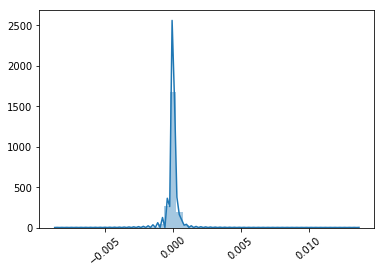

In [5]:
sns.distplot(y)
plt.xticks(rotation=40)
plt.show()

In [6]:
abs(y).describe()

count    1.389235e+06
mean     1.850811e-04
std      2.673974e-04
min      1.767651e-10
25%      3.895205e-05
50%      9.651725e-05
75%      2.212690e-04
max      1.368628e-02
dtype: float64

### y correlations with X variables 

In [7]:
y_corr = X.corrwith(y, axis=0)
print('\n5 largest corr with y:\n{}'.format(y_corr.nlargest()))
print('\n5 smallest corr with y:\n{}'.format(y_corr.nsmallest()))


5 largest corr with y:
qitot_265.745    0.017621
qitot_311.373    0.017581
sphu_354.091     0.014866
sphu_390.897     0.014721
sphu_311.373     0.014042
dtype: float64

5 smallest corr with y:
tv_192.485     -0.013395
sphu_776.243   -0.010766
sphu_751.808   -0.010699
sphu_727.369   -0.010138
sphu_798.236   -0.009864
dtype: float64


### Train and predict (Linear Regression & Gradient Boosting)

In [8]:
# split train and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [9]:
# train Linear Regression
lr = LinearRegression()
lr.fit(X_train[cols_2D], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [10]:
# train Gradient Boosting
gbm = lgbm.LGBMRegressor(objective='regression', n_estimators=300, learning_rate=0.1, random_state=10)

gbm.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_names=('train', 'test'),
    eval_metric='l2',
    early_stopping_rounds=20,
    feature_name=X_train.columns.tolist(),
    verbose=False
)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=300,
       n_jobs=-1, num_leaves=31, objective='regression', random_state=10,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)

In [11]:
# predict LR
lr_pred = lr.predict(X_test[cols_2D])

In [12]:
# predict GBM
gbm_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

### Results

#### Linear Regression

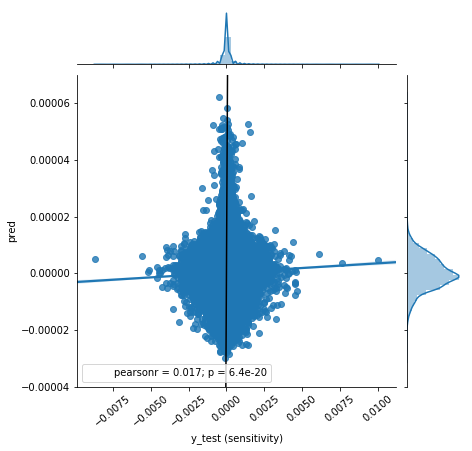

In [23]:
ax = sns.jointplot(x=y_test , y=lr_pred, kind="reg")
ax.annotate(stats.pearsonr)
ax.set_axis_labels(xlabel='y_test (sensitivity)', ylabel='pred')
# fix y axis limits
ax.ax_marg_y.set_ylim(-0.00004, 0.00007)
# add bissectrice (in black)
plt.plot([-0.0075, 0.0075], [-0.0075, 0.0075], 'k-')
# prevent x axis labels overlapping
plt.xticks(rotation=40)
plt.show()

#### Gradient Boosting

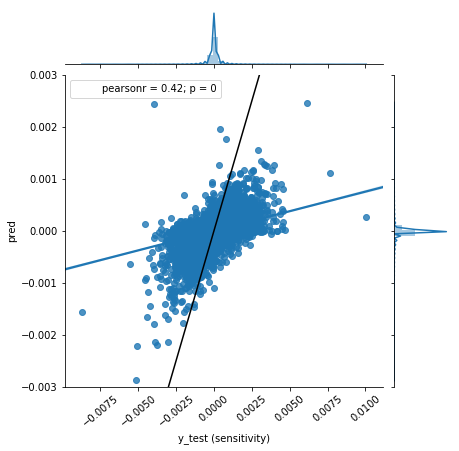

In [24]:
ax = sns.jointplot(x=y_test , y=gbm_pred, kind="reg")
ax.annotate(stats.pearsonr)
ax.set_axis_labels(xlabel='y_test (sensitivity)', ylabel='pred')
# fix y axis limits
ax.ax_marg_y.set_ylim(-0.003, 0.003)
# add bissectrice (in black)
plt.plot([-0.0075, 0.0075], [-0.0075, 0.0075], 'k-')
# prevent x axis labels overlapping
plt.xticks(rotation=40)
plt.show()

#### Mean Squared Error

In [15]:
print('Only zeros MSE: {0:.4g}' .format(mean_squared_error(y_test, [0]*len(y_test))))
print('AMSUA LR MSE:   {0:.4g}' .format(mean_squared_error(y_test, lr_pred)))
print('AMSUA GBM MSE:  {0:.4g}' .format(mean_squared_error(y_test, gbm_pred)))

Only zeros MSE: 1.053e-07
AMSUA LR MSE:   1.053e-07
AMSUA GBM MSE:  9.29e-08


#### Compute statistics about real sensitivity and pred sensitivity ratio

In [16]:
ratio = pd.Series(y_test/gbm_pred)
ratio.describe()

count    2.778470e+05
mean    -5.646840e+01
std      3.127818e+04
min     -1.643922e+07
25%     -5.980340e+00
50%      1.389743e+00
75%      9.598295e+00
max      7.611103e+05
dtype: float64

#### Display ratio pdf

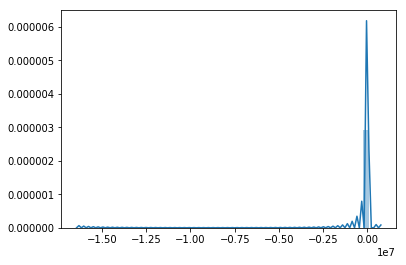

In [17]:
ax = sns.distplot(ratio, norm_hist=True)

#### % of ratio values between ]-5:5[

In [18]:
print('{0:.2f}%' .format(len(ratio[(ratio > -5) & (ratio < 5)])/len(ratio)*100))

37.80%


#### Display ratio between ]-5:5[ pdf

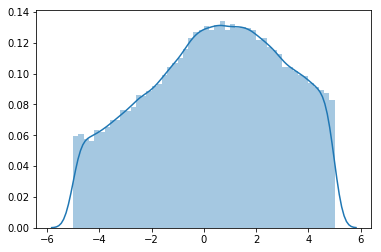

In [19]:
filtered = ratio[(ratio > -5) & (ratio < 5)]
ax = sns.distplot(filtered)

#### % of ratio values between ]0.5:1.5[

In [20]:
print('{0:.2f}%' .format(len(ratio[(ratio > 0.5) & (ratio < 1.5)])/len(ratio)*100))

4.96%


#### % of ratio negative sign

In [21]:
print('{0:.2f}%' .format(len(ratio[ratio < 0])/len(ratio)*100))

43.14%


#### % of ratio values ≈ 0

In [22]:
print('{0:.2f}%' .format(len(ratio[abs(ratio) < 1e-3])/len(ratio)*100))

0.01%
